In [1]:
%reset -f

In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Set-up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

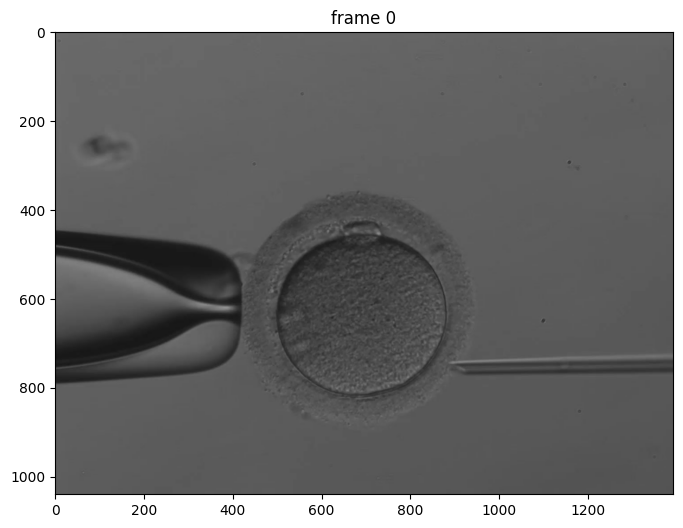

In [7]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/icsi"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.savefig("./videos/frame_0.jpg")

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 2703/2703 [01:29<00:00, 30.09it/s]


In [9]:
predictor.reset_state(inference_state)

In [10]:
prompts = {}


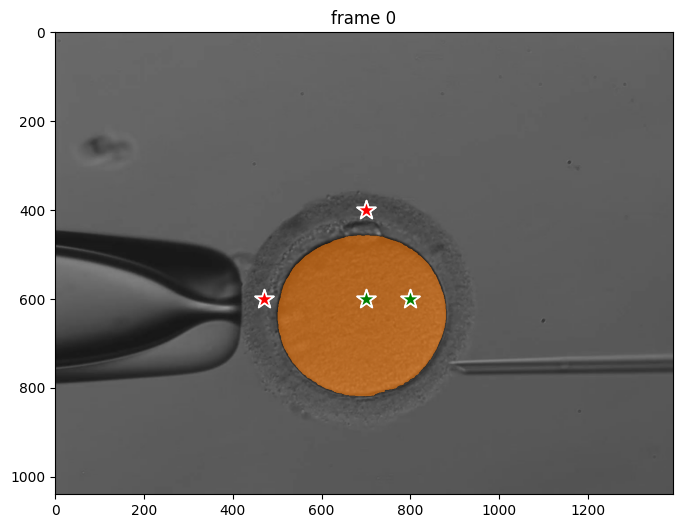

In [11]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
# points = np.array([[700, 600], [800, 600]], dtype=np.float32)
points = np.array([[700, 400], [470, 600], [700, 600], [800, 600]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0, 0, 1, 1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

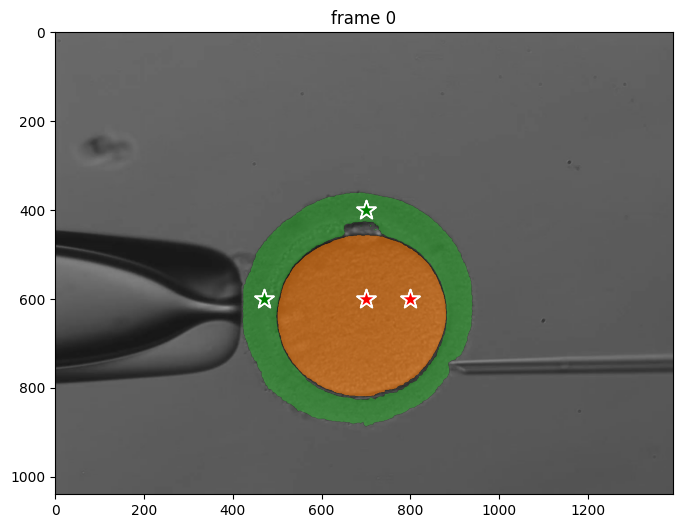

In [12]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[700, 400], [470, 600], [700, 600], [800, 600]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

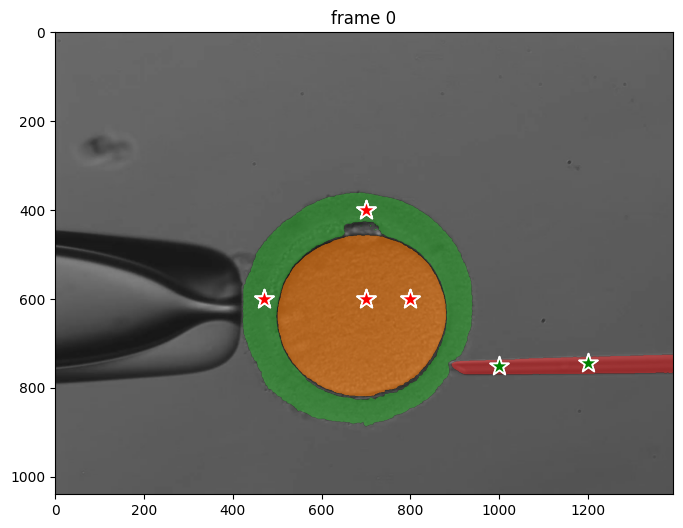

In [16]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[700, 400], [470, 600], [700, 600], [800, 600], [1000,750], [1200, 745]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0, 0, 0, 0, 1,1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [17]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:  18%|█▊        | 488/2703 [07:37<11:34:47, 18.82s/it]

In [ ]:
# Save segmentation results
import pickle
with open('./videos/complete_cell_needle_test_1.pkl', 'wb') as fp:
    pickle.dump(video_segments, fp)
    print('dictionary saved successfully to file')

In [1]:
# render the segmentation results every few frames
%reset -f

import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import io
from PIL import Image
import numpy as np

matplotlib.use("Agg")

video_dir = "./videos/icsi"

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def fig2img(fig): 
    buf = io.BytesIO() 
    fig.savefig(buf) 
    buf.seek(0) 
    img = Image.open(buf) 
    return img 


with open('./videos/complete_cell_needle_test_1.pkl', 'rb') as handle:
    video_segments = pickle.load(handle)

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# out = cv2.VideoWriter('./videos/icsi_test2/test2.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 20, (600, 400))
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
for out_frame_idx in range(len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.axis("off")
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    plt.savefig(f"./videos/icsi_complete_cell_needle_segmented_test_1/{out_frame_idx}_mask.jpg")
    plt.close("all")
    # print(out_frame_idx)

